In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')
import os
import re as re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')
original = pd.read_csv('jm1.csv')

In [3]:
train.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


Description of the dataset:

In [4]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

TRAIN dataset:

In [5]:
summary(train)

data shape: (101763, 23)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
id,int64,0,0.0,101763,0.0,101762.0,0,1,2
loc,float64,0,0.0,378,1.0,3442.0,22.0,14.0,11.0
v(g),float64,0,0.0,106,1.0,404.0,3.0,2.0,2.0
ev(g),float64,0,0.0,71,1.0,165.0,1.0,1.0,1.0
iv(g),float64,0,0.0,84,1.0,402.0,2.0,2.0,2.0
n,float64,0,0.0,836,0.0,8441.0,60.0,32.0,45.0
v,float64,0,0.0,4515,0.0,80843.08,278.63,151.27,197.65
l,float64,0,0.0,55,0.0,1.0,0.06,0.14,0.11
d,float64,0,0.0,3360,0.0,418.2,19.56,7.0,8.05
i,float64,0,0.0,5171,0.0,569.78,14.25,21.11,22.76


TEST Dataset:

In [6]:
summary(test)

data shape: (67842, 22)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
id,int64,0,0.0,67842,101763.0,169604.00,101763.00,101764.00,101765.00
loc,float64,0,0.0,371,1.0,1891.00,33.00,27.00,130.00
v(g),float64,0,0.0,96,1.0,470.00,5.00,8.00,11.00
ev(g),float64,0,0.0,67,1.0,165.00,1.00,8.00,7.00
iv(g),float64,0,0.0,73,1.0,402.00,4.00,2.00,10.00
n,float64,0,0.0,828,0.0,8441.00,144.00,125.00,545.00
v,float64,0,0.0,4269,0.0,80843.08,824.82,646.24,3831.40
l,float64,0,0.0,54,0.0,1.00,0.04,0.04,0.02
d,float64,0,0.0,3106,0.0,418.20,26.96,22.82,48.15
i,float64,0,0.0,4855,0.0,569.78,30.05,27.22,66.17


original description:

In [7]:
rows_with_strings  = []
for col in original.select_dtypes(include=['object']).columns:
    original[col] = pd.to_numeric(original[col], errors= 'coerce')
    rows_with_strings += original[original[col].isna()].index.to_list()
# Print the rows containing strings in the numerical column
original = original.drop(rows_with_strings, axis=0)
summary(original)

data shape: (10880, 22)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
loc,float64,0,0.0,365,1.0,3442.0,1.1,1.0,72.0
v(g),float64,0,0.0,108,1.0,470.0,1.4,1.0,7.0
ev(g),float64,0,0.0,74,1.0,165.0,1.4,1.0,1.0
iv(g),float64,0,0.0,82,1.0,402.0,1.4,1.0,6.0
n,float64,0,0.0,806,0.0,8441.0,1.3,1.0,198.0
v,float64,0,0.0,3988,0.0,80843.08,1.3,1.0,1134.13
l,float64,0,0.0,55,0.0,1.3,1.3,1.0,0.05
d,float64,0,0.0,2693,0.0,418.2,1.3,1.0,20.31
i,float64,0,0.0,4265,0.0,569.78,1.3,1.0,55.85
e,float64,0,0.0,6975,0.0,31079782.27,1.3,1.0,23029.1


From the above description, we simply convert our target type from bool to int:

In [8]:
train['defects'] = train.defects.astype('int64')
original['defects'] = original.defects.astype('int64')

Using plotly, we plot as a pie the distribution of the target:

In [9]:
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)  
fig2 = px.pie(train, names='defects', 
             height=450, width=600, 
             hole=0.7, 
             title='Defects Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=14, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

fig2 = px.pie(original, names='defects', 
             height=450, width=600, 
             hole=0.7, 
             title='Defects Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=14, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

Now we plot the correlation of our numerical variables between themselves and with the target:

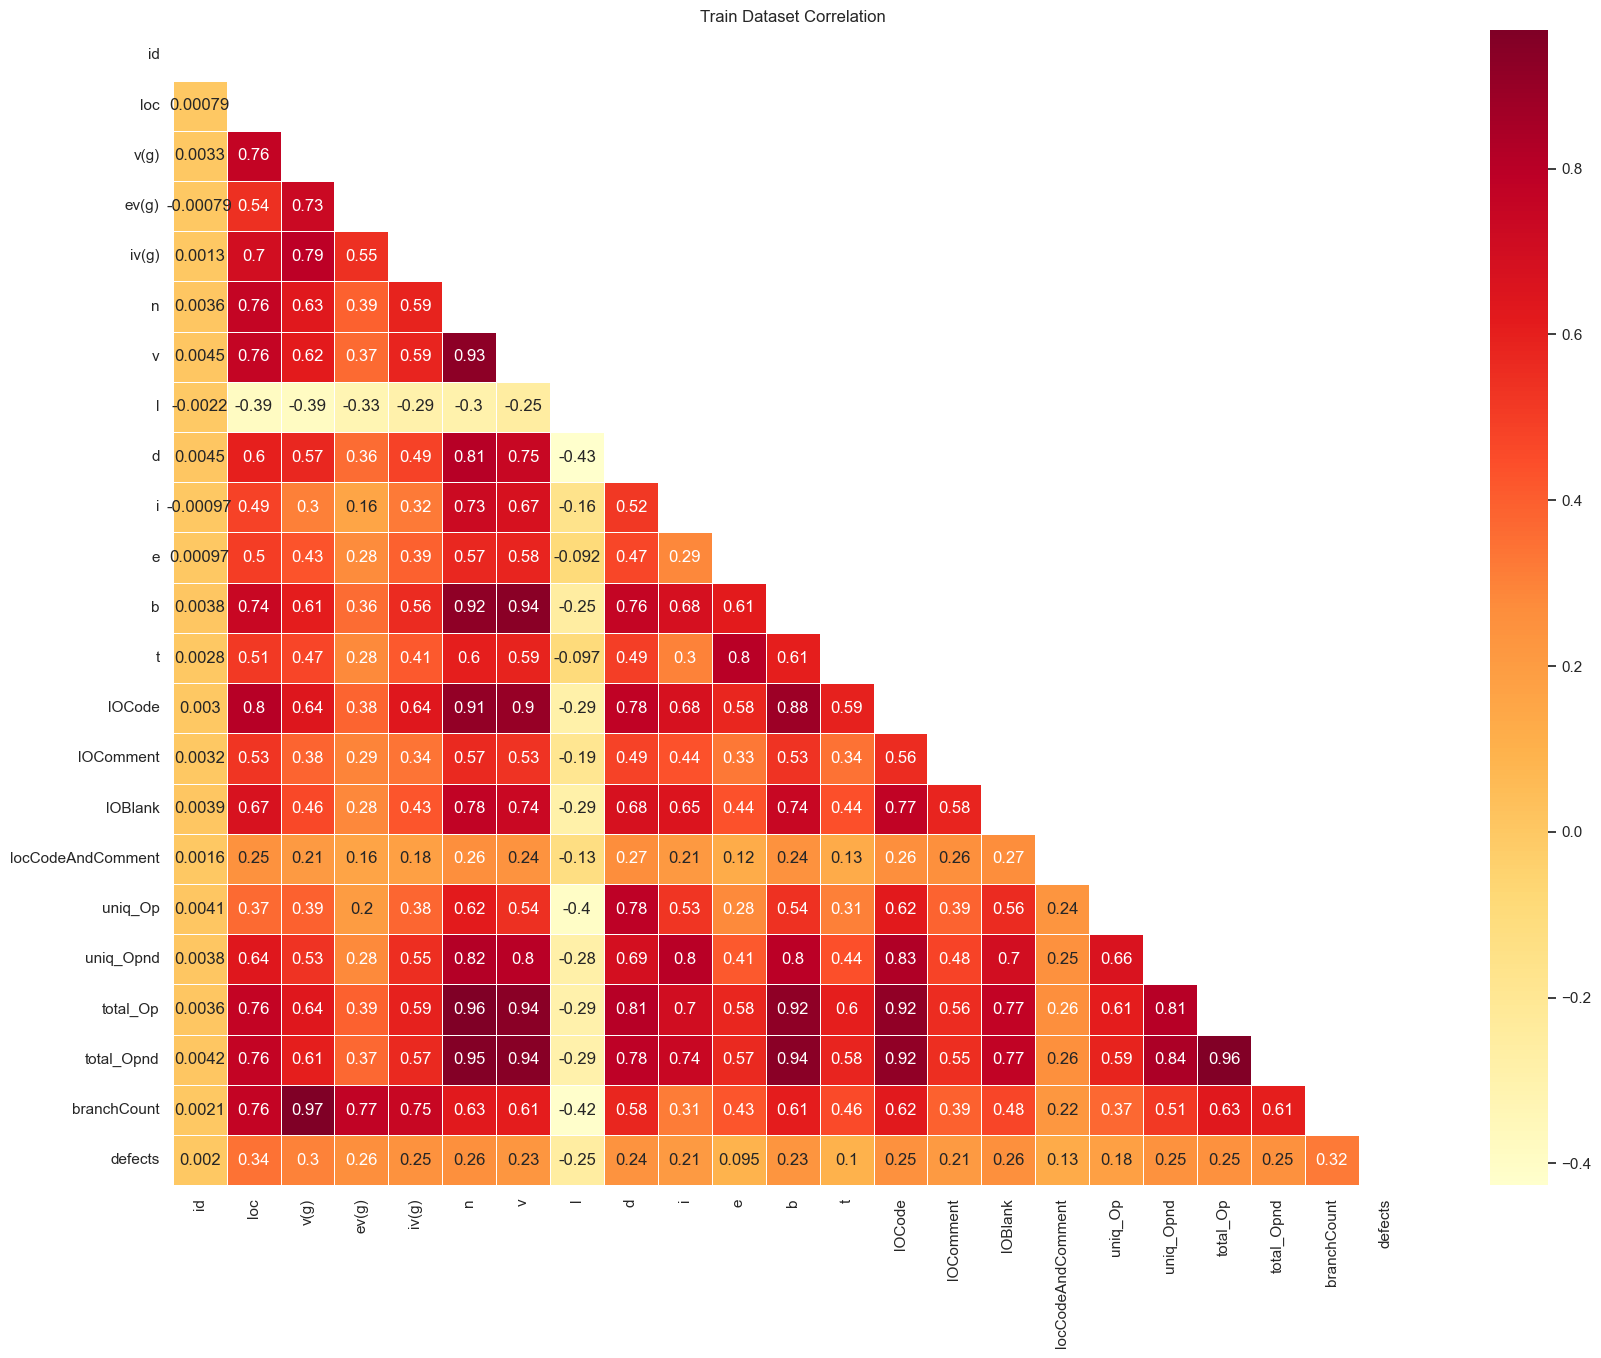

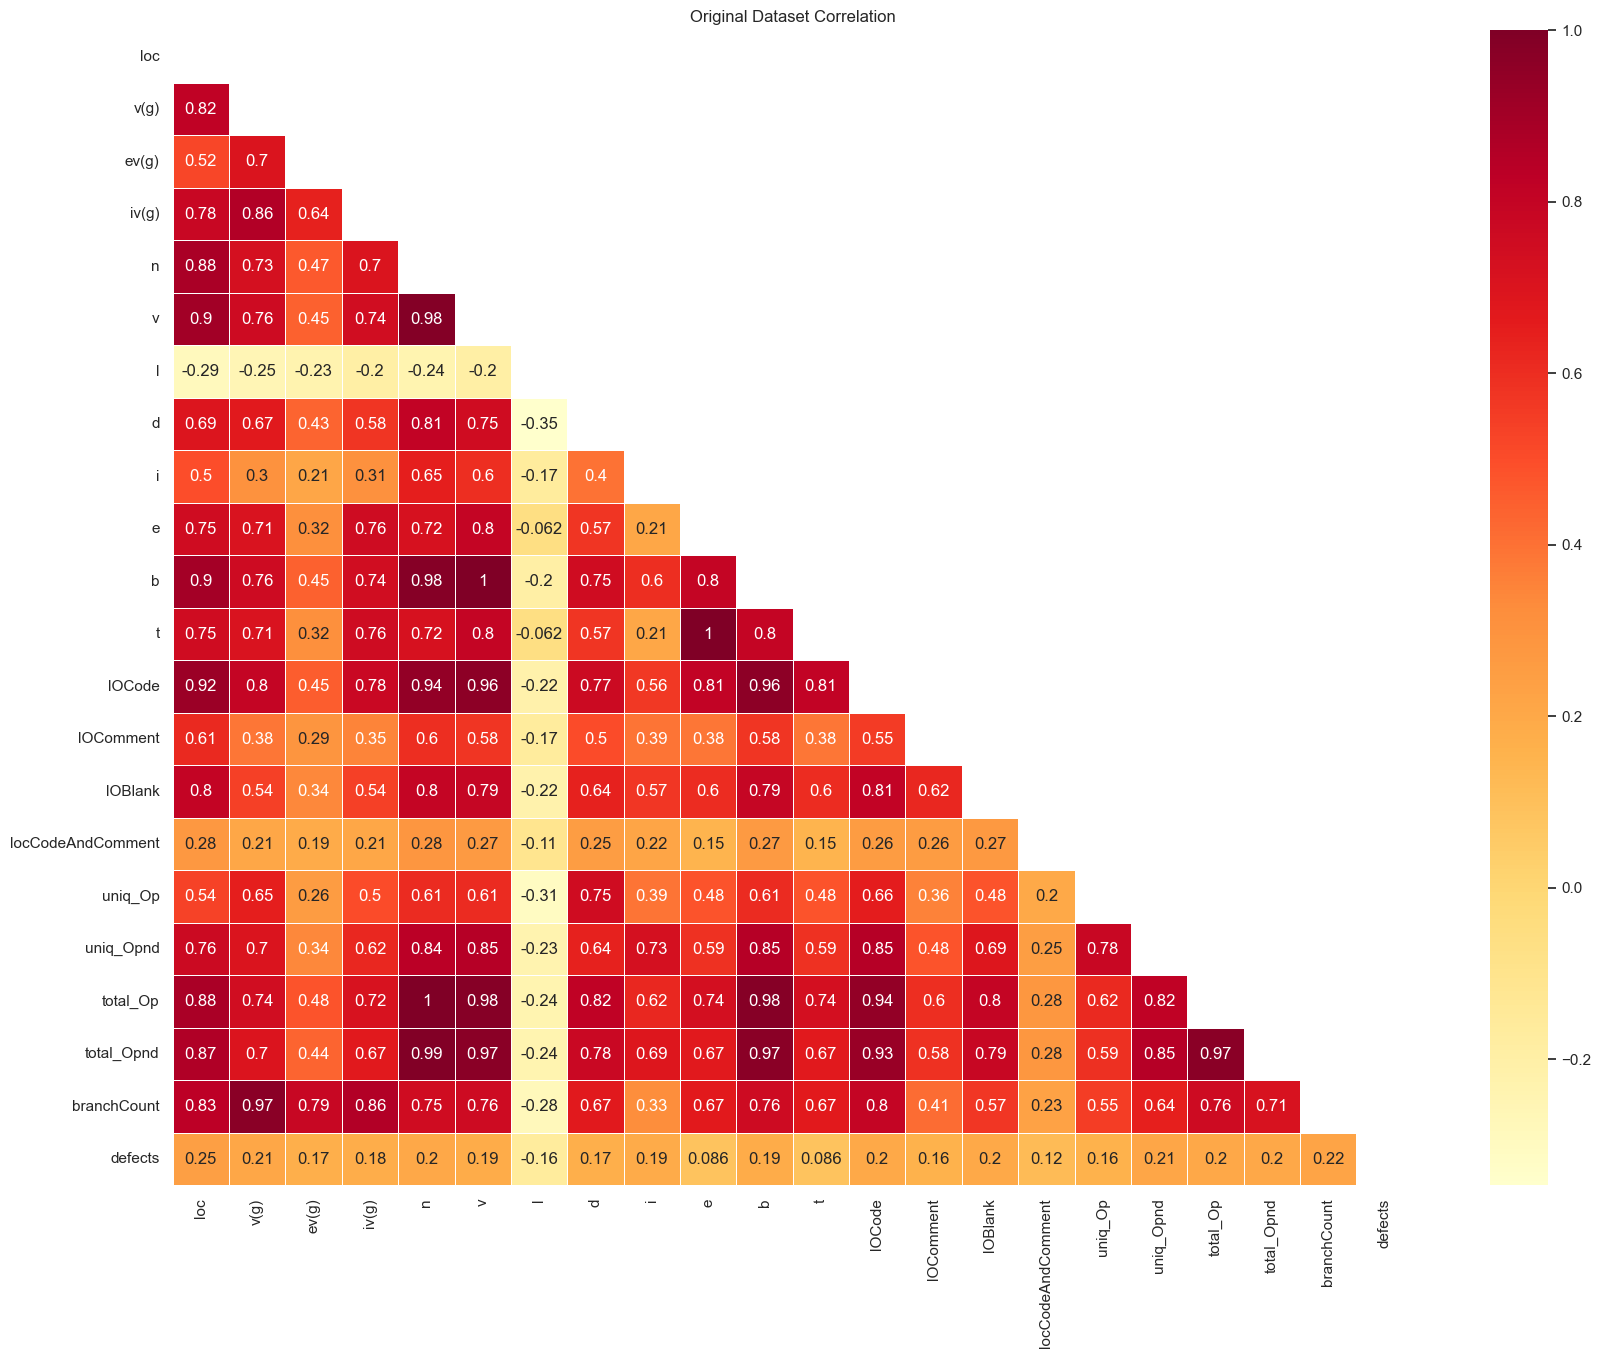

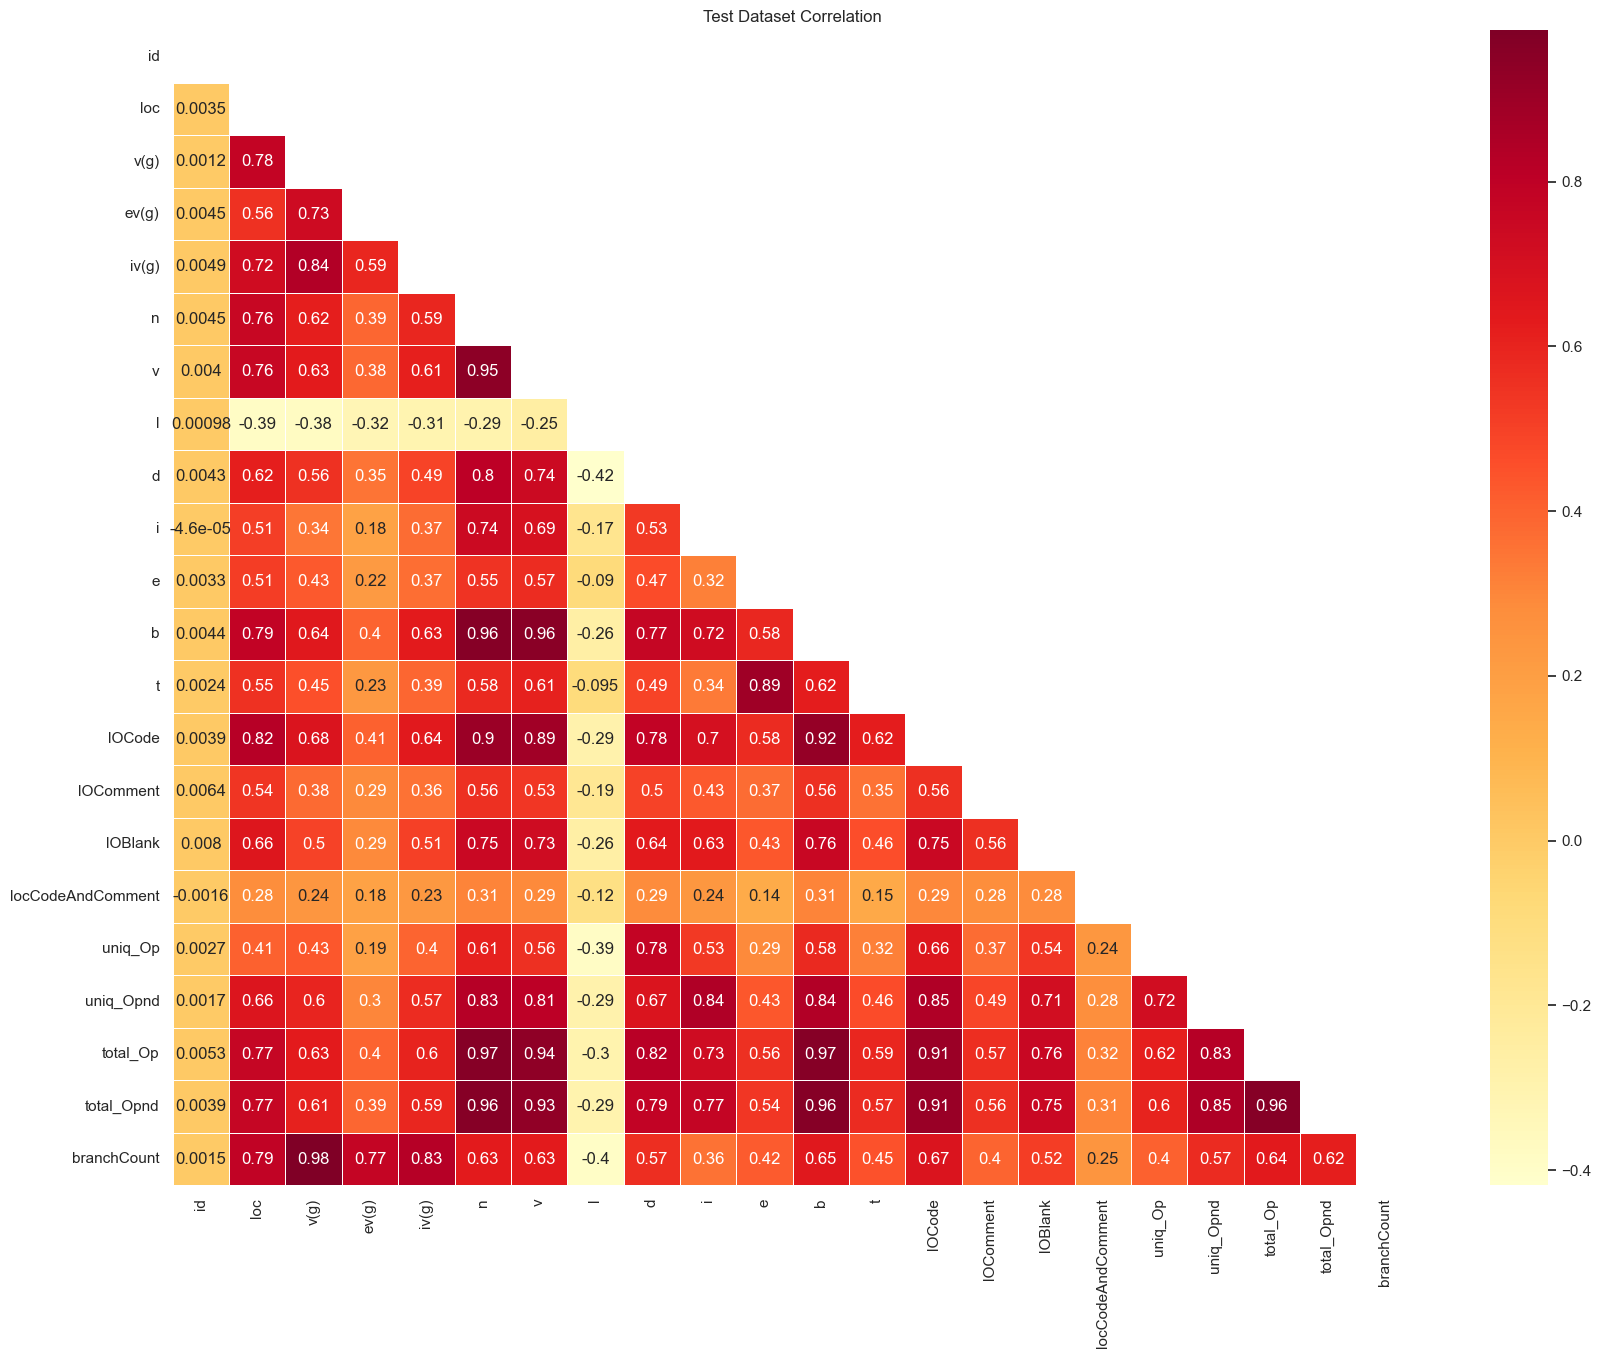

In [10]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 15))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

plot_correlation_heatmap(train, 'Train Dataset Correlation')
plot_correlation_heatmap(original, 'Original Dataset Correlation')
plot_correlation_heatmap(test, 'Test Dataset Correlation')

Now we compare the distribution of the numerical features of the test and train datasets:  
First we look for numerical features:

In [11]:
numerical_features = test._get_numeric_data().drop(['id'], axis=1).columns

Then, we plot their histogram / density:

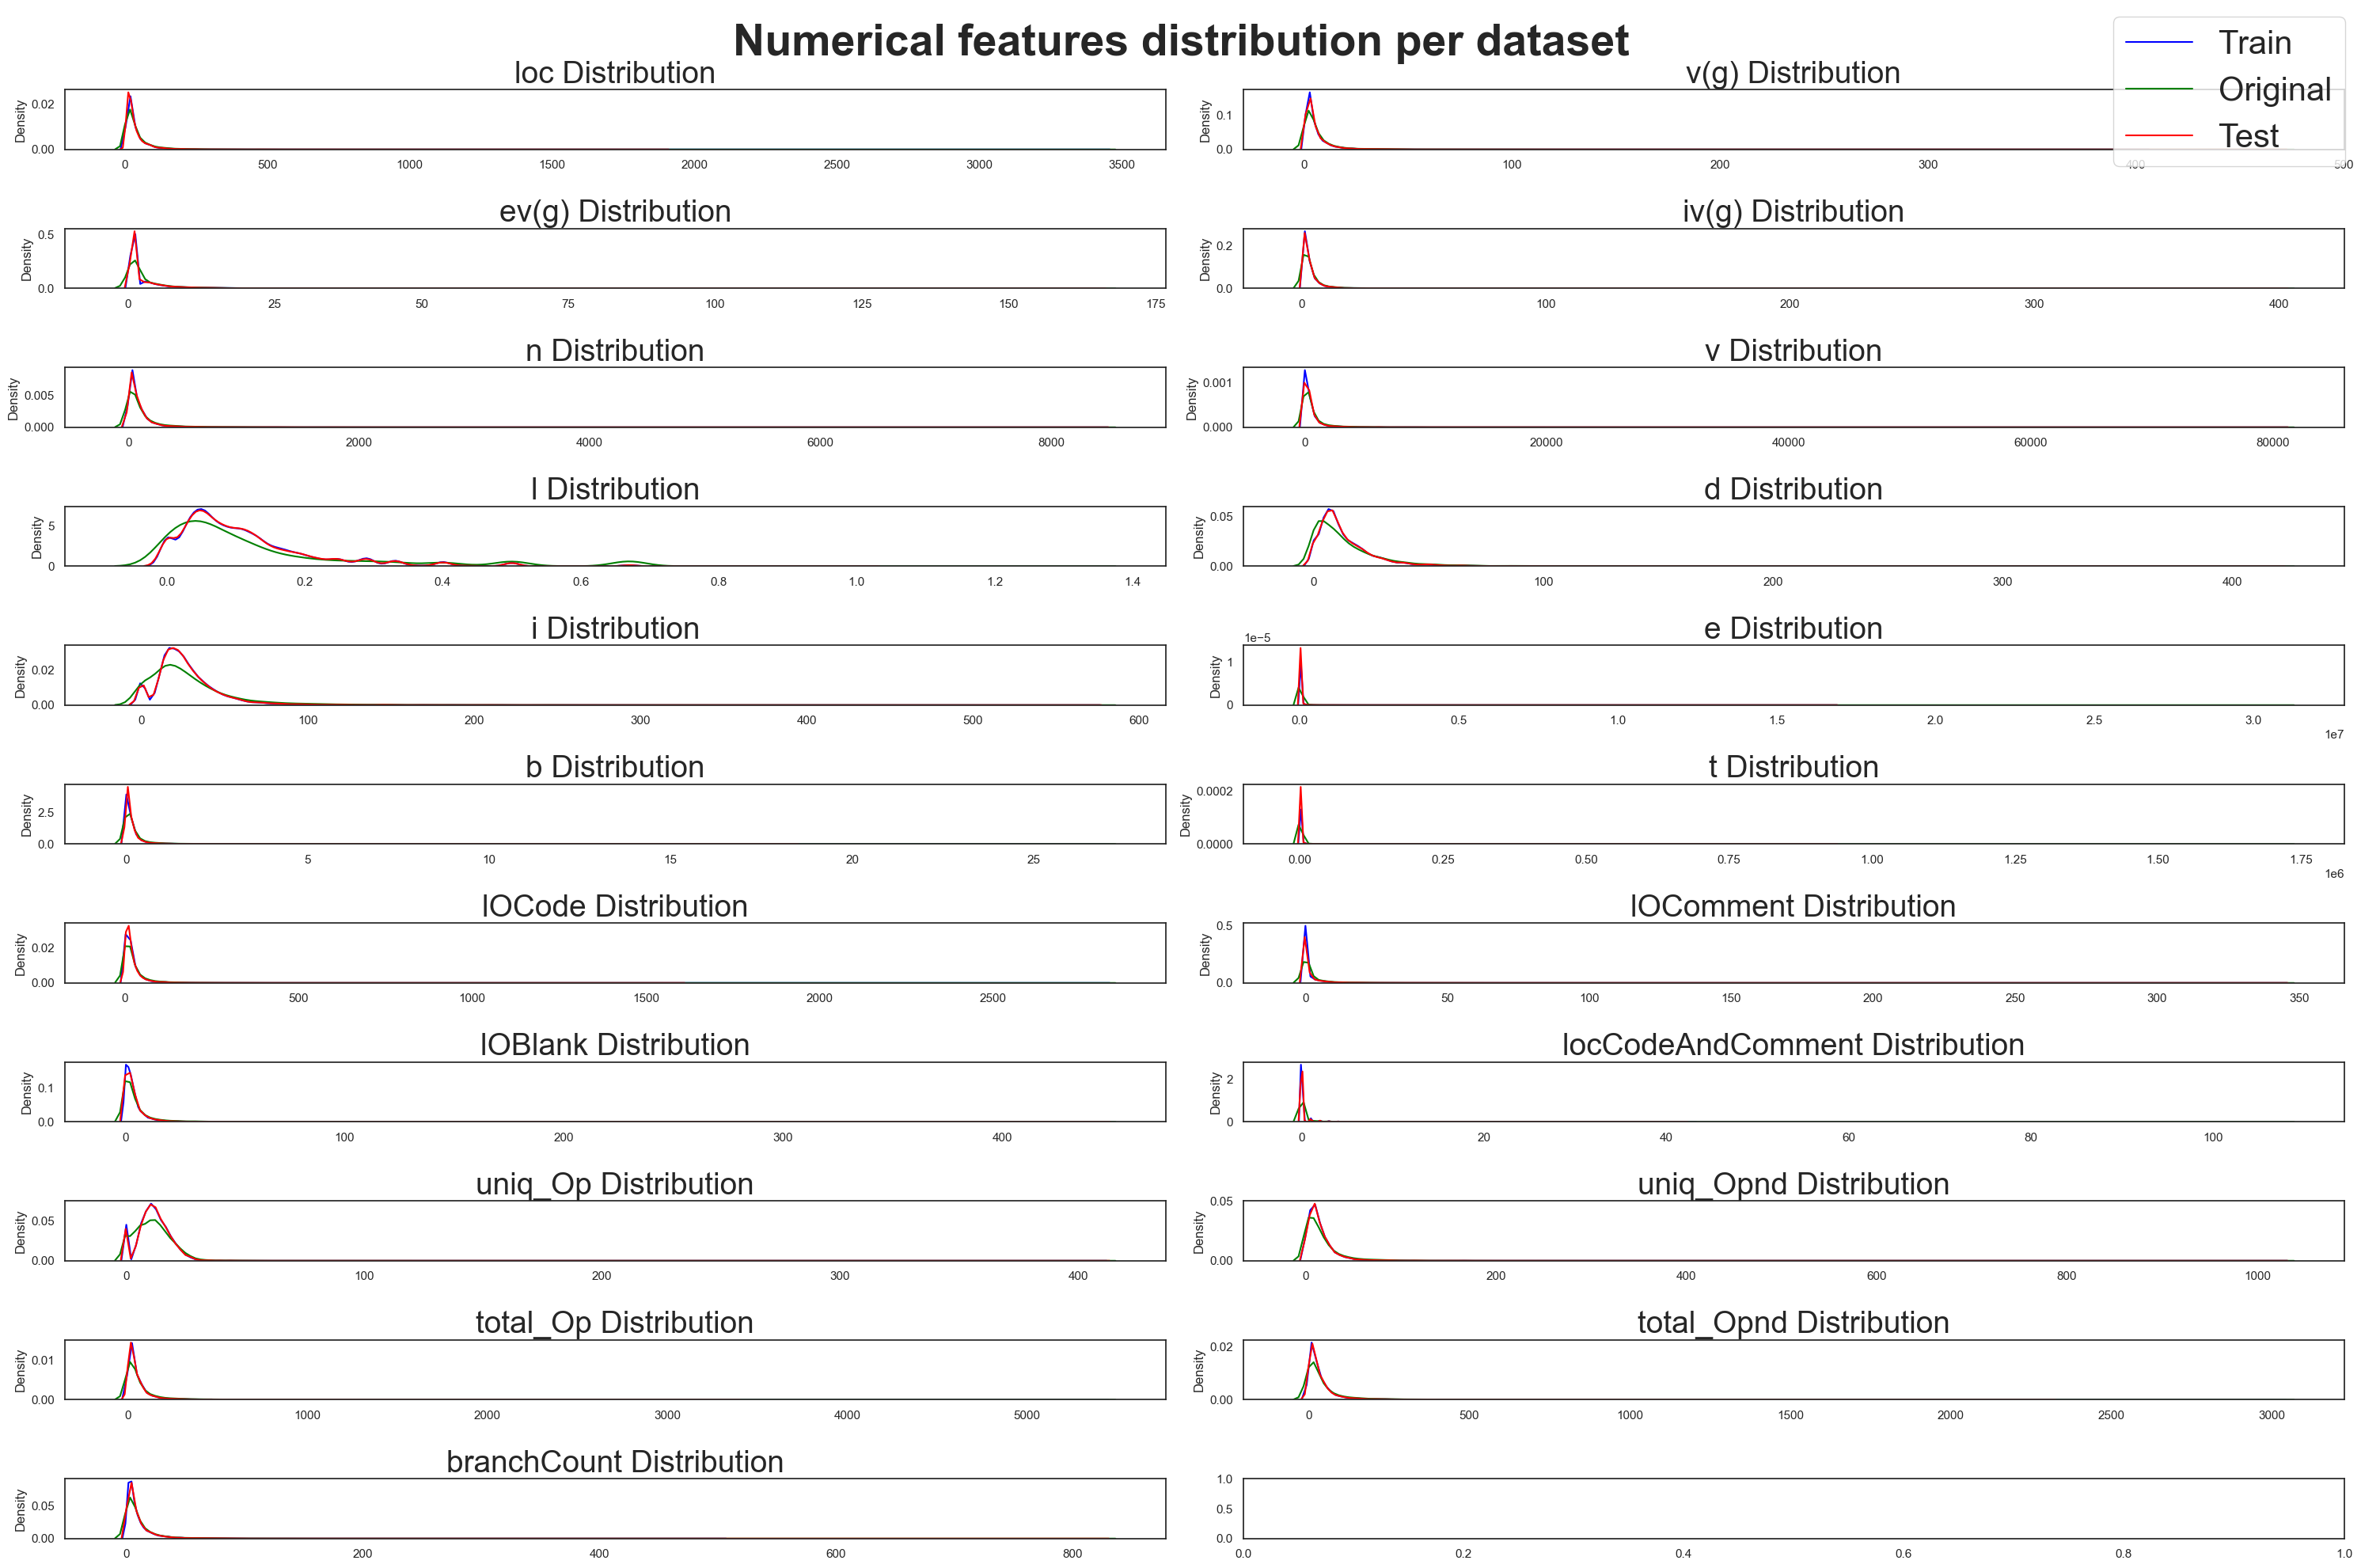

In [12]:
fig, ax = plt.subplots(len(numerical_features) // 2 + 1, 2, figsize = (30, 20))
ax = ax.flatten()
for i, column in enumerate(numerical_features):
    
    sns.kdeplot(train[column], ax=ax[i], color='blue')
    sns.kdeplot(original[column], ax=ax[i], color='green')
    sns.kdeplot(test[column], ax=ax[i], color='red', warn_singular = False)
    
    ax[i].set_title(f'{column} Distribution', size = 28)
    ax[i].set_xlabel(None)

fig.suptitle('Numerical features distribution per dataset', fontsize=40,
              fontweight='bold')
fig.legend(['Train', 'Original', 'Test'], fontsize=30)
plt.tight_layout()

**original is a bit different from test / train so we don't include it**

### Adversarial validation

The purpose of adversarial validation is to check whether train and test dataset have similar distribution or not. If the validation gives ROC-AUC score of close to .5, we can say that both datasets are similar. However, if it's far from .5, both dataset have different distribution.

The reason we want to do this is to make sure that we can trust our CV score, since a trusted CV only comes from dataset with similar distribution.

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

def adversarial_validation(dataset_1 = train, dataset_2 = test, label = 'Train-Test'):

    # adv_train = dataset_1.drop(['defects', 'id'], axis = 1)
    adv_train = dataset_1.drop(['id'], axis = 1)
    # adv_test = dataset_2.drop(['id'], axis = 1)
    adv_test = dataset_2.copy()

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index = True)

    adv_shuffled = adv.sample(frac = 1)

    adv_X = adv_shuffled.drop('is_test', axis = 1)
    adv_y = adv_shuffled.is_test

    skf = StratifiedKFold(n_splits = 5, random_state = 69, shuffle = True)

    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
    
        adv_lr = XGBClassifier(random_state = 69)
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])
        
        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)
    
    print(f"Score de validation sur le test: test ou train dataset:{np.mean(val_scores):.3f}")
    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)
    print(len(fpr))
    
    plt.figure(figsize = (10, 10), dpi = 300)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr[0:-1:100], y=tpr[0:-1:100], label="Adversarial Validation Classifier")
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight = 'bold', size = 17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

Score de validation sur le test: test ou train dataset:0.670
25998


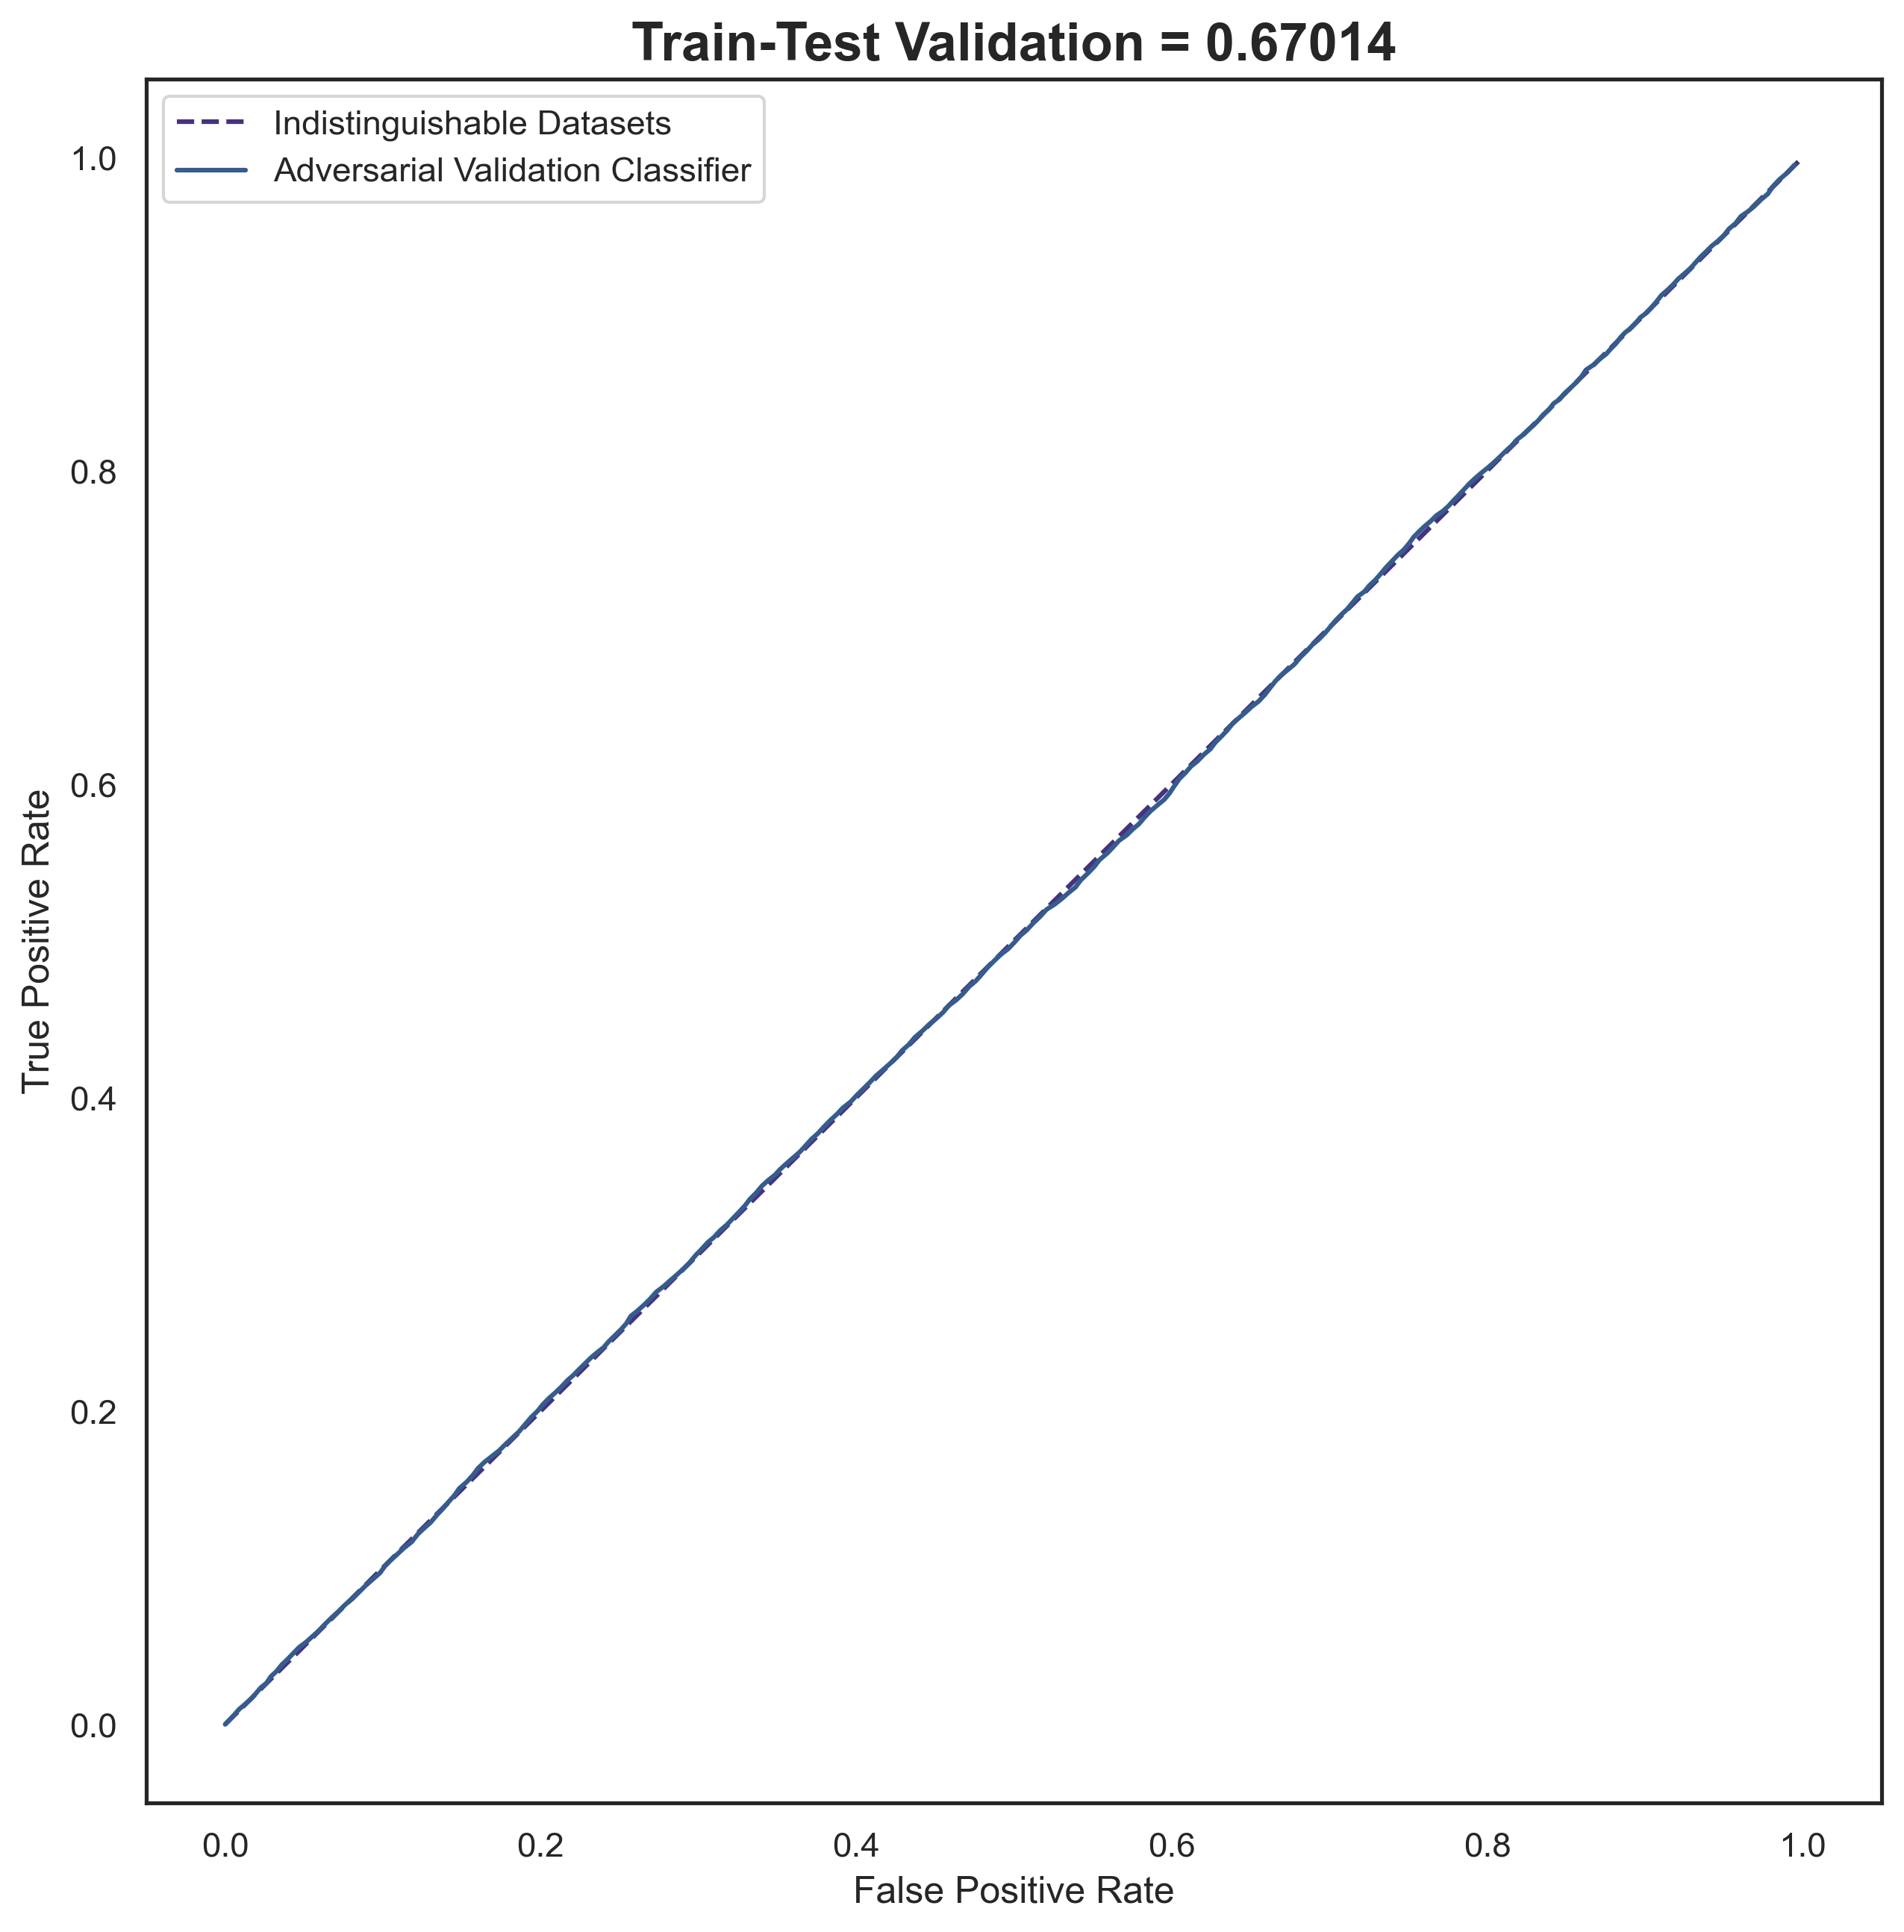

In [14]:
adversarial_validation(train, original)

### Random Forest baseline study:

Let's implement a nice GridSearch:

##### Make the above code into an effective function:

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def hyperparemeters_search(model, xtrain, ytrain, param_grid, prev_best_score,
  name_model, name_file_params, name_file_score, seed=69):
    
    # create a stratified kfold as the data isn't balanced:
    kfolds = StratifiedKFold(6, shuffle=True, random_state=seed)

    # # Create a GridSearchCV object with cross-validation (e.g., 5-fold)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
    cv=kfolds.split(xtrain,ytrain), scoring='roc_auc')

    # # Fit the GridSearchCV object to the data
    grid_search.fit(xtrain, ytrain)

    # Print the best hyperparameters and corresponding accuracy score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(name_model)
    print("Best Hyperparameters:", best_params)
    print(f"Best Accuracy Score: {best_score:.5f}")

    # if the current model score is above previous best score, update parameters:
    if prev_best_score < best_score:
      # save dictionary to rf_best_params.txt file
      with open(name_file_params + '.txt', 'w') as fp:
          json.dump(best_params, fp, cls= NpEncoder)

      # save roc_auc to rf_best_score.txt file
      with open(name_file_score + '.txt', 'w') as fp:
          json.dump(best_score, fp)
          print('New best score for:'+name_model + 'congrats!')

    return best_score




def train_test_save(model, model_name, xtrain, ytrain, xtest):
    
    # best score on full training set name file:
    score_on_full_X_filename = 'best_training_score'
    # Train the classifier on the total train set with the best hyperparameters:
    model.fit(xtrain, ytrain)

    #Test it on train set then on test set:
    y_train_pred_prob = model.predict_proba(xtrain)[:, 1]  # Probability of the positive class
    y_test_pred_prob = model.predict_proba(xtest)[:, 1]  # Probability of the positive class

    # print_result on the train set:
    roc_auc = roc_auc_score(ytrain, y_train_pred_prob)
    
    # get the current best score on full X train set:
    with open(score_on_full_X_filename + '.txt', 'r') as fp:
        current_best_score = json.load(fp)
    
    if current_best_score < roc_auc:
        # save roc_auc to rf_best_score.txt file
        with open(score_on_full_X_filename + '.txt', 'w') as fp:
            json.dump(roc_auc, fp)
            print(f'New best score for full X training set! The performing model is:{model_name}')

    # print the result of the tested model:
    print("ROC AUC Score of the tested model on FULL training set:", roc_auc)

    return y_test_pred_prob, model


def save_parameters(name_file_params, param_grid):
    with open(name_file_params + '.txt', 'w') as fp:
          json.dump(param_grid, fp, cls = NpEncoder)


### Data improvement (adding data, pca)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#define seed:
seed = 69

# CHOOSE IF only select train and original dataset and split X and Y training sets
original['id'] = seed
train_extend = pd.concat([train, original], axis=0)
train_extend = train
# features to del from feature selection below for lightGBM
X = train_extend.drop(['id','defects'], axis=1)
Y = train_extend['defects']
# X = train.drop(['id','defects'], axis=1)
# Y = train['defects']
X_test = test.drop(['id'], axis=1)
print(X.shape, X_test.shape)

# Standardization of the datas:
SS = StandardScaler()
SS.fit(X)
X_norm = SS.transform(X)
X_test_norm = SS.transform(X_test)

# PCA of the training data:
# n_components = 10
# pca = PCA(n_components=n_components, random_state=seed)
# pca.fit(X_norm)
# print(f'''avec les {n_components} premieres composantes de
#       la pca, la variance expliquée est de:
#       {pca.explained_variance_ratio_.sum():.4f}''')
# X_pca = pd.DataFrame(pca.transform(X_norm), index=X.index)
# X_pca.rename(columns=lambda x: 'pca_' + str(x), inplace=True)
# X = pd.concat([X, X_pca], axis=1)
# X_test_pca = pd.DataFrame(pca.transform(X_test_norm), index=X_test.index)
# X_test_pca.rename(columns=lambda x: 'pca_' + str(x), inplace=True)
# X_test= pd.concat([X_test, X_test_pca], axis=1)

# after suppression from pca + previous feature selection:
# features_to_del = ['branchCount', 'lOCode', 't', 'l', 'iv(g)', 'locCodeAndComment']
# X = X.drop(features_to_del, axis=1)
# X_test = X_test.drop(features_to_del, axis=1)

(101763, 21) (67842, 21)


#### Choice of model, hyperparameter optimisation

In [35]:
list(range(100,501,100))

[100, 200, 300, 400, 500]

In [42]:
#-----------------------------------------------------
# Create a Random Forest classifier
# define file names:
# name_model='random forest'
# name_file_params=name_model + '_best_params'
# name_file_score= name_model + "_best_score"
# classifier = RandomForestClassifier(random_state=seed)

# # Define a parameter grid to search
# param_grid = {
#     'n_estimators': [200],
#     'max_depth': [15],
#     'min_samples_split': [10],
#     'min_samples_leaf': [1],
#     'max_features': ['auto']
# }
# param_grid={}
#--------------------------------------------------------

# Create a xgboost classifier
# define file names:
# name_model='XGBClassifier'
# name_file_params= name_model + '_best_params'
# name_file_score= name_model +  "_best_score"
# classifier = XGBClassifier(random_state=seed)

# # Define a parameter grid to search
# param_grid = {
#     'n_estimators': [200],
#     'max_depth': [7],
#     'learning_rate': [0.01],
#     'subsample': [0.3]
# }
# param_grid={}
#--------------------------------------------------------

# Create a HISTGBclassifier
# define file names:
name_model='HISTGBClassifier'
name_file_params= name_model + '_best_params'
name_file_score= name_model +  "_best_score"

FIXED_PARAMS={
              'max_iter':180,
              'random_state' : seed,
              'learning_rate': 1/3,
              'max_depth': 8,
              "max_leaf_nodes": 20,
              "min_samples_leaf": 20

            }

classifier = HistGradientBoostingClassifier(**FIXED_PARAMS)

# # Define a parameter grid to search
param_grid = {
    'learning_rate': np.linspace(0.025,0.05,4),
}
# param_grid={}
#--------------------------------------------------------

# Create a GBclassifier
# define file names:
# name_model='GBClassifier'
# name_file_params= name_model + '_best_params'
# name_file_score= name_model +  "_best_score"
# # classifier = GradientBoostingClassifier(random_state=seed)

#FIXED_PARAMS = { max_depth= 9
# min_samples_split= 600
# n_estimators= 100
# max_features = 4
# min_samples_leaf = 50
# subsample = 0.8
# learning_rate = 0.05
# classifier = GradientBoostingClassifier(n_estimators=n_estimators, 
#                                         learning_rate=learning_rate,
#                                         random_state=seed,max_depth=max_depth,
#                                         min_samples_leaf=min_samples_leaf,
#                                         min_samples_split=min_samples_split,
#                                         max_features=max_features,
#                                           subsample=subsample)

# param_grid = {"max_depth": [9],
# # "min_samples_split": [600],
# "n_estimators":[100],
# # "max_features": [4],
# # "min_samples_leaf" :[50],
# # "subsample" : [0.8],
# "learning_rate" : [0.05],
# 'random_state': seed}
# param_grid = {}
#--------------------------------------------------------

# Create a lightGBMclassifier
# define file names:
# name_model='LGBMClassifier'
# name_file_params= name_model + '_best_params'
# name_file_score= name_model +  "_best_score"
# classifier = LGBMClassifier(random_state=seed)
# param_grid = {'num_iteration':[100]}

#--------------------------------------------------------
# Create a lightGBMclassifier with dart boosting type
# define file names:
# name_model='dartLGBMClassifier'
# name_file_params= name_model + '_best_params'
# name_file_score= name_model +  "_best_score"
# FIXED_PARAMS={'objective': 'binary',
#               'metric': 'auc',
#               'boosting':'dart',
#               'n_estimators':500,
#               # 'early_stopping_rounds':30,
#               'random_state' : seed,
#               'learning_rate': 0.1,
#               'max_depth': 9,
#               'feature_fraction':0.7,
#               'num_leaves': 12,
#               'subsample': 1}

# classifier = LGBMClassifier(**FIXED_PARAMS)
# # param_grid= {'learning_rate': np.linspace(0.01,0.1,8)}
# param_grid = {}



#--------------------------------------------------------
# Create a Catboostclassifier with dart boosting type
# define file names:
# name_model='CatBoostClassifier'
# name_file_params= name_model + '_best_params'
# name_file_score= name_model +  "_best_score"
# classifier = CatBoostClassifier(random_state=seed)
# param_grid = {}

#-----------------------------------------------------------------------------

# load current best modele score:
if os.path.exists(name_file_score + '.txt'):
    with open(name_file_score + '.txt', 'r') as fp:
        prev_best_score = json.load(fp)
else:
    prev_best_score = 0
    print("Nouveau model testé: prev best score = 0")

print(f'Before new training, the best roc_auc score for {name_model} is {prev_best_score:.5f}')


Before new training, the best roc_auc score for HISTGBClassifier is 0.79190


## Launch hyperparameter search:


In [43]:
best_cv_score = hyperparemeters_search(model=classifier, xtrain=X, ytrain=Y,
param_grid=param_grid, prev_best_score=prev_best_score,
name_model=name_model, name_file_params=name_file_params,
  name_file_score= name_file_score)

HISTGBClassifier
Best Hyperparameters: {'learning_rate': 0.03333333333333333}
Best Accuracy Score: 0.79191
New best score for:HISTGBClassifiercongrats!


Save best parameters combination:

In [44]:
FIXED_PARAMS={
              'max_iter':180,
              'random_state' : seed,
              'learning_rate': 1/3,
              'max_depth': 8,
              "max_leaf_nodes": 20,
              "min_samples_leaf": 20

            }
save_parameters(name_file_params, FIXED_PARAMS)

Load the best parameters and train the best classifier then submit:

In [46]:
# adding results on the test dataset and creating the submission csv file
 ### load best params:
 # load current best modele score:
with open(name_file_params+'.txt', 'r') as fp:
    best_params = json.load(fp)
classifier = classifier.set_params(**best_params)
test['defects'], model = train_test_save(classifier, name_model, X, Y, X_test)
test[['id', 'defects']].to_csv('submission.csv', index=False)
test['defects_' + name_model] = test['defects']
test.drop(['defects'], axis=1, inplace=True)

ROC AUC Score of the tested model on FULL training set: 0.8008366912055587


## Selection de variables ##

In [47]:
# Plot feature importances
# import lightgbm as lgb
# lgb.plot_importance(model, max_num_features=X.shape[1] + n_components, figsize=(10, 6))
# plt.show()
importances=model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in model.booster_.estimators_],axis=0)
# print(std.shape)
sorted_idx = np.argsort(importances)[::-1]
features =X.columns
print(features[sorted_idx])
padding = np.arange(X.size/len(X)) + 0.5
plt.barh(padding, importances[sorted_idx]/sum(importances), align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'feature_importances_'

#### We look for the best number of feature to select for lightgbm

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ig

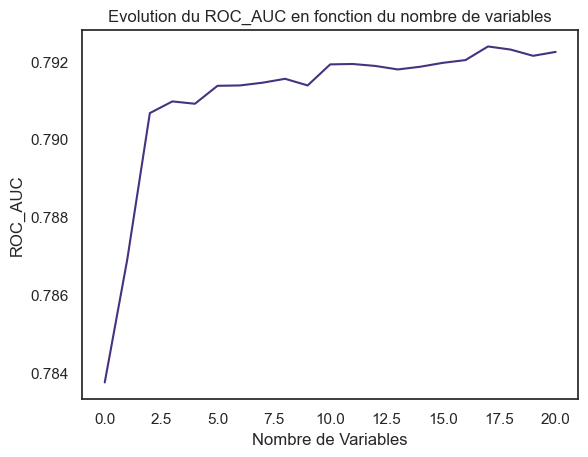

In [69]:
scores=np.zeros(len(features))
for f in np.arange(0, len(features)):
    
    X_f = X.iloc[:,sorted_idx[:f+1]]
   
    with open(name_file_score + '.txt', 'r') as fp:
        prev_best_score = json.load(fp)
    
    with open(name_file_params + '.txt', 'r') as fp:
        best_params = json.load(fp)
        
    score = hyperparemeters_search(model=classifier,
                                    xtrain=X_f,
                                      ytrain=Y,
                                      param_grid={},
                                        prev_best_score=prev_best_score,
                                        name_model=name_model,
                                          name_file_params=name_file_params,
                                          name_file_score= name_file_score)
    scores[f]=np.round(score,5)

    
print("Selection de variables pour le model")
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("ROC_AUC")
plt.title("Evolution du ROC_AUC en fonction du nombre de variables")
plt.show()


then we give the figures relative to the result:

In [70]:
unimportant_features = X.iloc[:,sorted_idx[np.argmax(scores):]].columns.to_list()
print(np.argmax(scores), max(scores), len(scores))
print(unimportant_features)
name_file_features_to_del = name_model + '_features_to_del'
with open(name_file_features_to_del + '.txt', 'w') as fp:
          json.dump(unimportant_features, fp)

17 0.79238 21
['n', 'ev(g)', 'lOComment', 'b']


We now make a cross validation to find the best parameters on the chosen features:

In [71]:
print(best_params)

{'objective': 'binary', 'metric': 'auc', 'boosting': 'dart', 'n_estimators': 500, 'random_state': 69, 'learning_rate': 0.1, 'max_depth': 9, 'feature_fraction': 0.7, 'num_leaves': 12, 'subsample': 1}


In [50]:
model_names = []

name_model='HISTGBClassifier'
name_file_params= name_model + '_best_params'
with open(name_file_params + '.txt', 'r') as fp:
        best_params = json.load(fp)
classifier = HistGradientBoostingClassifier(**best_params)
# X_f = X.iloc[:,sorted_idx[:np.argmax(scores)+1]]
# X_test_f = X_test.iloc[:,sorted_idx[:np.argmax(scores)+1]]
test['defects_' + name_model], _ = train_test_save(classifier, name_model, X, Y, X_test)
model_names.append(name_model)

name_model='dartLGBMClassifier'
name_file_params= name_model + '_best_params'
with open(name_file_params + '.txt', 'r') as fp:
        best_params = json.load(fp)
classifier = LGBMClassifier(**best_params)
# X_f = X.iloc[:,sorted_idx[:np.argmax(scores)+1]]
# X_test_f = X_test.iloc[:,sorted_idx[:np.argmax(scores)+1]]
test['defects_' + name_model], _ = train_test_save(classifier, name_model, X, Y, X_test)
model_names.append(name_model)

name_model='GBClassifier'
name_file_params= name_model + '_best_params'
with open(name_file_params + '.txt', 'r') as fp:
        best_params = json.load(fp)
classifier = GradientBoostingClassifier(**best_params)
test['defects_' + name_model], _ = train_test_save(classifier, name_model, X, Y, X_test)
model_names.append(name_model)


ROC AUC Score of the tested model on FULL training set: 0.8008366912055587
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
ROC AUC Score of the tested model on FULL training set: 0.8044705637663688


JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 109 (char 108)

determining weights coefficients for ensemble predictions:

In [ ]:
columns_target = [column for column in test.columns if column.startswith('defects_')]
best_scores = []
for model_name in model_names :
    with open(model_name + '_best_score.txt', 'r') as fp:
        best_scores.append(json.load(fp))
ensemble_weights = np.array(best_scores) / np.array(best_scores).sum()

NameError: name 'model_names' is not defined

Ensemble predictions:

In [20]:
for i in range(0,len(best_scores)):
    test['defects_'+model_names[i]] = test['defects_'+model_names[i]] * ensemble_weights[i]

test['defects'] = test[columns_target].sum(axis=1)
test[['id', 'defects']].to_csv('submission.csv', index=False)
test.drop(['defects'], axis=1, inplace=True)
